In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
plt.rcParams.update({'font.size': 16})

### Get all the data for subjects, agents of interest

In [2]:
def load_subject_data(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh["session"] = session
    return beh

def load_agent_data(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh["session"] = session
    return beh

In [3]:
subject_to_data = {}

In [4]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
sam_res = pd.concat(sessions.apply(lambda x: load_subject_data(x, beh_path), axis=1).values)
sam_res["subject"] = "Monkey S"
subject_to_data["Monkey S"] = sam_res

In [5]:
# Monkey B
sessions = pd.DataFrame({"session_name": [20190123, 20190124, 20190125, 20190128, 20190312, 20190313, 20190329]})
beh_path = "/data/rawdata/sub-BL/sess-{sess_name}/behavior/sub-BL_sess-{sess_name}_object_features.csv"
blanche_res = pd.concat(sessions.apply(lambda x: load_subject_data(x, beh_path), axis=1).values)
blanche_res["subject"] = "Monkey B"
subject_to_data["Monkey B"] = blanche_res

In [7]:
AGENT_BEH_DIR = "/data/patrick_res/rl/beh"
agent_to_model_names = {
    "Task RNN": "two_step_block_switching", 
    "Prob 0.75 RNN": "two_step_block_switching_prob0.75", 
    "Matching RNN": "shared_belief_rnn_prob_matches_sam_0_beta_0.75", 
    # "Separate Matching": "separate_belief_rnn_prob_matches_sam_0_beta_0.75",
    "Optimal": "optimal_agent",
    "Feature RL": "fitted_feature_rl",
    "Feature RL w Decay": "fitted_feature_rl_w_decay",
    "Belief State S": "fitted_belief_state_agent",
    "Belief State B": "fitted_belief_state_agent_BL",
}
for i, (agent_name, model_name),  in enumerate(agent_to_model_names.items()):
    session_name = "{sess_name}"
    beh_path = f"/data/patrick_res/rl/beh/{model_name}_session_{session_name}.csv"
    sessions = pd.DataFrame({"session_name": np.arange(10)})
    agent_res = pd.concat(sessions.apply(lambda x: load_agent_data(x, beh_path), axis=1).values)
    agent_res["subject"] = agent_name
    subject_to_data[agent_name] = agent_res

In [8]:
all_data = pd.concat(subject_to_data.values())
# sub_data = all_data[all_data.subject.isin(["Optimal RNN", "Feature RL", "Belief State", "Matching RNN", "Monkey S"])]
# sub_data = all_data[all_data.subject.isin(["Optimal RNN", "Feature RL", "Feature RL w Decay", "Belief State", "Matching RNN", "Monkey S"])]
# agent_list_w_monkey = ["Task RNN", "Feature RL w Decay", "Belief State", "Matching RNN", "Monkey Beh"]
agent_list_w_monkey = ["Monkey S",  "Belief State S", "Monkey B", "Belief State B", ]

sub_data = all_data[all_data.subject.isin(agent_list_w_monkey)]


### Plot Prob Correct

[Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10'), Text(15, 0, '15')]

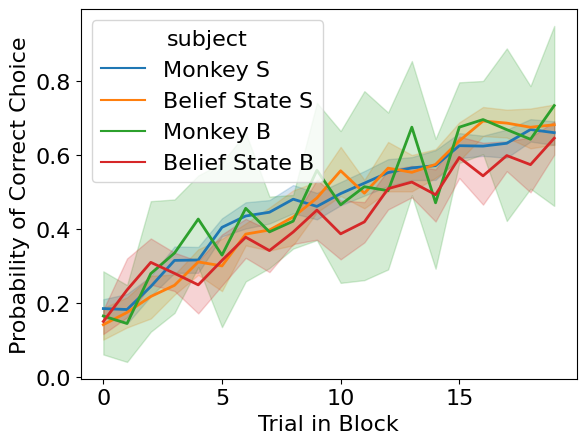

In [9]:

res = sub_data.groupby(["subject", "session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_correct_by_block_pos(group, 20)).reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=res, x="TrialInBlock", y="ProbCorrect", hue="subject", hue_order=agent_list_w_monkey, ax=ax, linewidth=2)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Correct Choice") 
ax.set_xticks([0, 5, 10, 15])
ax.set_xticklabels([0, 5, 10, 15])
# ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")

### Plot block lengths

In [10]:
def get_block_lengths(beh):
    res = beh.groupby("BlockNumber", group_keys=True).TrialNumber.nunique().reset_index()
    return res.rename(columns={"TrialNumber": "Average Block Length"})

block_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(get_block_lengths).reset_index()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'Monkey S'),
 Text(1, 0, 'Belief State S'),
 Text(2, 0, 'Monkey B'),
 Text(3, 0, 'Belief State B')]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


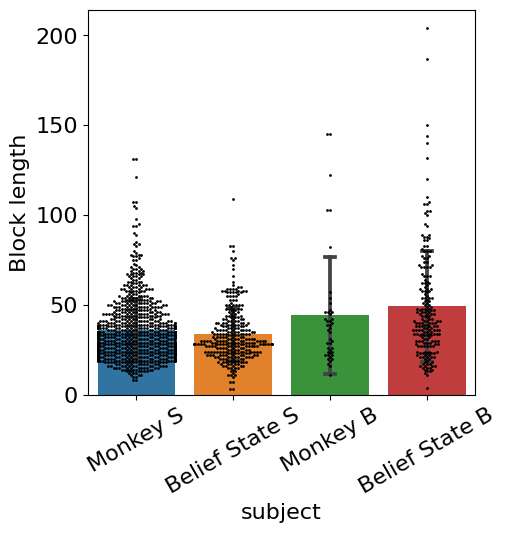

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=block_res, x="subject", y="Average Block Length", errorbar='sd', capsize=.1, order=agent_list_w_monkey, ax=ax)
sns.swarmplot(data=block_res, x="subject", y="Average Block Length", color="0", size=2, order=agent_list_w_monkey, alpha=1, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### Plot Average Reward Rates

In [12]:
def avg_reward_rate(beh):
    return pd.Series({"Reward Rate": len(beh[beh.Response == "Correct"]) / len(beh)})
reward_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(avg_reward_rate).reset_index()


[Text(0, 0, 'Monkey S'),
 Text(1, 0, 'Belief State S'),
 Text(2, 0, 'Monkey B'),
 Text(3, 0, 'Belief State B')]

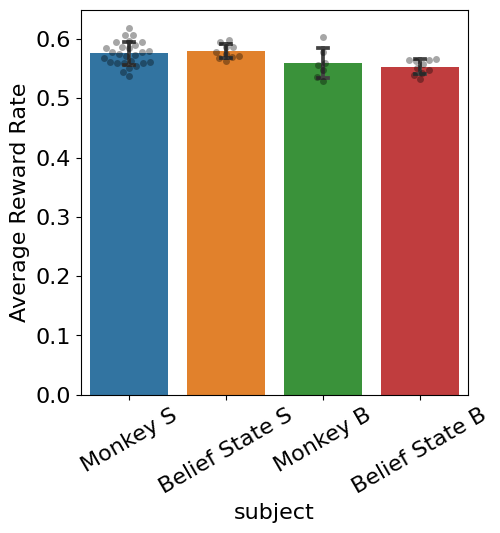

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=reward_res, x="subject", y="Reward Rate", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
sns.swarmplot(data=reward_res, x="subject", y="Reward Rate", order=agent_list_w_monkey, color="0", alpha=.35, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Average Reward Rate")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### Plot Perseveration Probabilities

[<matplotlib.lines.Line2D object at 0x7c6ee0956140>, <matplotlib.lines.Line2D object at 0x7c6ee0956440>, <matplotlib.lines.Line2D object at 0x7c6ee09566e0>, <matplotlib.lines.Line2D object at 0x7c6ee09569e0>]
['Monkey S', 'Belief State S', 'Monkey B', 'Belief State B']


[Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10')]

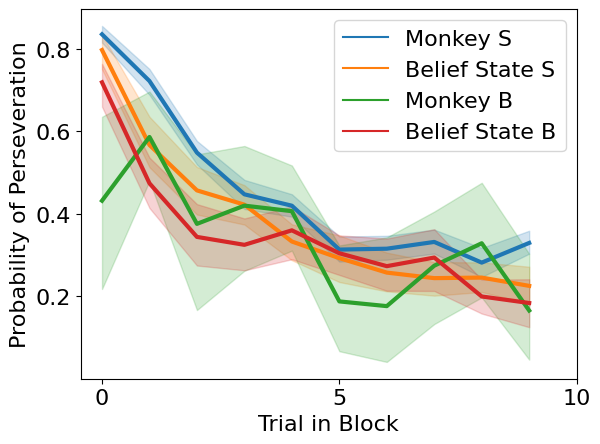

In [14]:
pers_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_perseveration_by_block_pos(group, 10)).reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=pers_res, x="TrialInBlock", y="Prob Perseverate", hue="subject", hue_order=agent_list_w_monkey, linewidth=3, ax=ax)
handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)
ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Perseveration") 
ax.set_xticks([0, 5, 10])
ax.set_xticklabels([0, 5, 10])
# ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")


### Negative log likelihood of agents
with data from notebooks/wcst/20240930_compute_beh_nll_for_rnns.ipynb 

In [15]:
all_nll_res = pd.read_pickle("/data/patrick_res/behavior/models/agent_fits_w_rnns.pickle")
agent_list = ["Task RNN", "Feature RL w Decay", "Belief State", "Matching RNN"]
sub_nll_res = all_nll_res[all_nll_res.agent.isin(agent_list)]

Text(0, 0.5, 'Average NLL of monkey card choice')

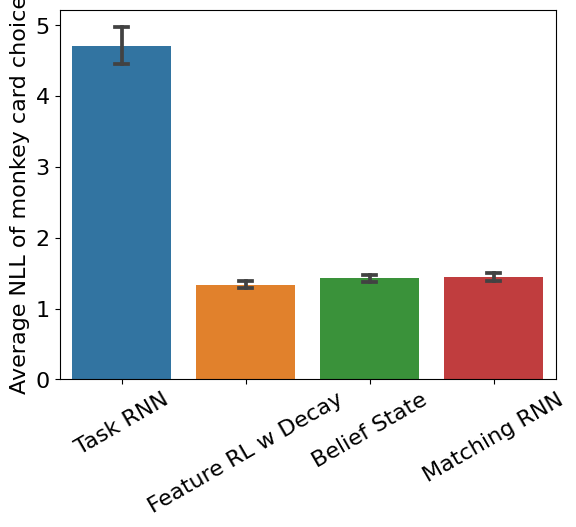

In [16]:
fig, ax = plt.subplots()
sns.barplot(sub_nll_res, x="agent", y="mean_nll2", order=agent_list, capsize=.1, errorbar="sd", ax=ax)
# sns.swarmplot(data=sub_res, x="agent", y="mean_nll2", order=agent_list, color="0", alpha=.35, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("")
ax.set_ylabel("Average NLL of monkey card choice")


### 2025 Cosyne Figure 1: Likelihood and Perseveration, Avg reward, Block Length

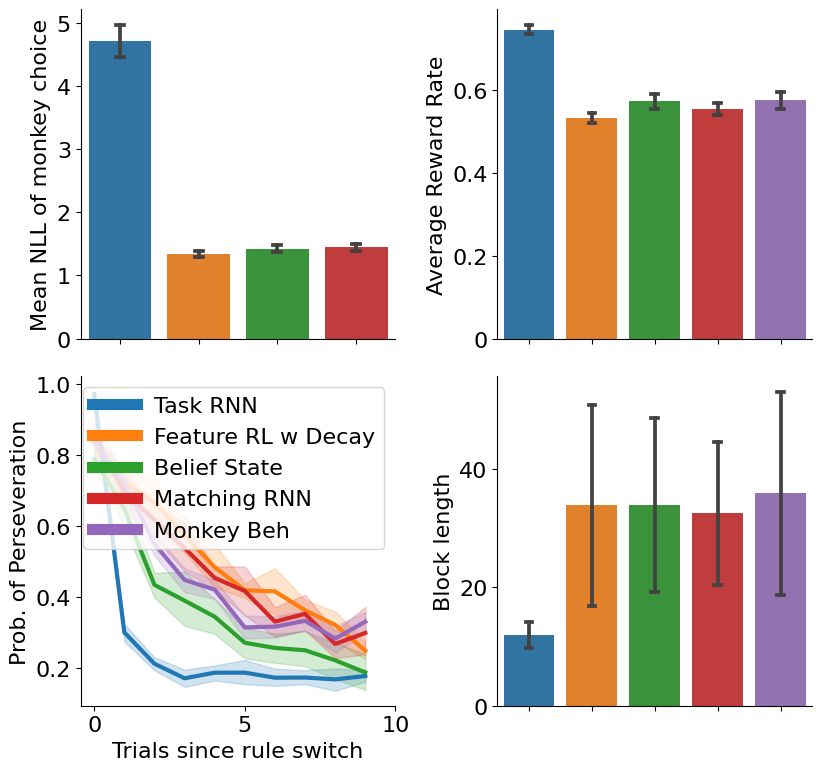

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 8))
ax = axs[0, 0]
sns.barplot(sub_nll_res, x="agent", y="mean_nll2", order=agent_list, capsize=.1, errorbar="sd", ax=ax)
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_ylabel("Mean NLL of monkey choice")
ax.spines[['right', 'top']].set_visible(False)

ax = axs[0, 1]
sns.barplot(data=reward_res, x="subject", y="Reward Rate", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
ax.set_ylabel("Average Reward Rate")
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_yticklabels([0, 0.2, 0.4, 0.6])
ax.spines[['right', 'top']].set_visible(False)


ax = axs[1, 0]
sns.lineplot(data=pers_res, x="TrialInBlock", y="Prob Perseverate", hue="subject", hue_order=agent_list_w_monkey, linewidth=3, ax=ax)
handles, labels = ax.get_legend_handles_labels()
# print(handles)
# print(labels)
ax.legend(handles=handles, labels=labels)
for line in ax.legend().get_lines():
    line.set_linewidth(8)
ax.set_xlabel("Trials since rule switch")
ax.set_ylabel("Prob. of Perseveration") 
ax.set_xticks([0, 5, 10])
ax.set_xticklabels([0, 5, 10])
ax.spines[['right', 'top']].set_visible(False)

ax = axs[1, 1]
sns.barplot(data=block_res, x="subject", y="Average Block Length", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
# sns.swarmplot(data=reses, color="0", alpha=.35, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xticklabels("")
ax.set_yticks([0, 20, 40])
ax.set_yticklabels([0, 20, 40])
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)



fig.tight_layout()
fig.savefig("/data/patrick_res/figures/2025_cosyne_abstract/beh_combined.svg")

### Plot a gif of feature values within a block

In [19]:
session = 20180802
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, beh)
block = beh[beh.BlockNumber == 8]


In [20]:
block

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,TRIANGLEValue,CYANValue,GREENValue,MAGENTAValue,YELLOWValue,ESCHERValue,POLKADOTValue,RIPPLEValue,SWIRLValue,MaxFeat
166,201,8,0,NaN,917,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.086062,0.150971,0.349988,0.103317,0.113578,0.181299,0.181007,0.100406,0.055992,SQUARE
167,202,8,1,NaN,835,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.062298,0.022579,0.253345,0.074788,0.082215,0.052908,0.131025,0.072681,0.040531,SQUARE
168,203,8,2,NaN,802,Incorrect,1.0,8,CIRCLE,SQUARE,...,-0.045095,0.016344,0.183388,0.054136,-0.012693,0.038298,0.036117,0.052611,0.029339,GREEN
169,204,8,3,NaN,1027,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.070930,0.011831,0.157553,0.039188,-0.009188,0.027723,0.026144,0.026776,0.021238,SQUARE
170,205,8,4,NaN,973,Incorrect,2.0,8,CIRCLE,SQUARE,...,-0.051344,0.008564,0.114047,0.028367,-0.050082,0.020068,0.018925,-0.014118,0.015373,MAGENTA
171,206,8,5,NaN,623,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.037166,0.006199,0.082555,0.025450,-0.036253,0.014526,0.013699,-0.017035,0.011128,SQUARE
172,207,8,6,NaN,726,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.026903,0.004488,0.059759,0.018422,-0.057186,-0.006407,0.009916,-0.012331,0.008055,SQUARE
173,208,8,7,NaN,678,Correct,0.0,8,CIRCLE,SQUARE,...,-0.019475,-0.018250,0.043258,0.013335,-0.041395,-0.004637,0.007178,-0.008926,-0.014682,CIRCLE
174,209,8,8,NaN,850,Incorrect,2.0,8,CIRCLE,SQUARE,...,-0.018770,0.199442,0.041692,0.012853,-0.039897,0.213055,0.006918,-0.008603,-0.014151,CYAN
175,210,8,9,NaN,672,Correct,0.0,8,CIRCLE,SQUARE,...,-0.013587,0.171216,0.030180,0.009304,-0.028880,0.154224,-0.021308,-0.006228,-0.010243,CYAN


/tmp/ipykernel_929389/1508423736.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


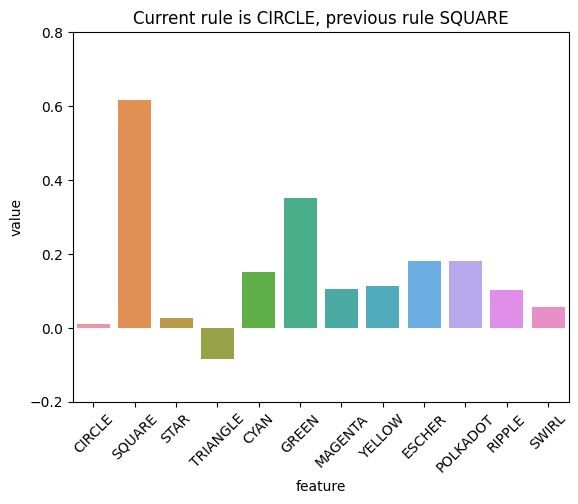

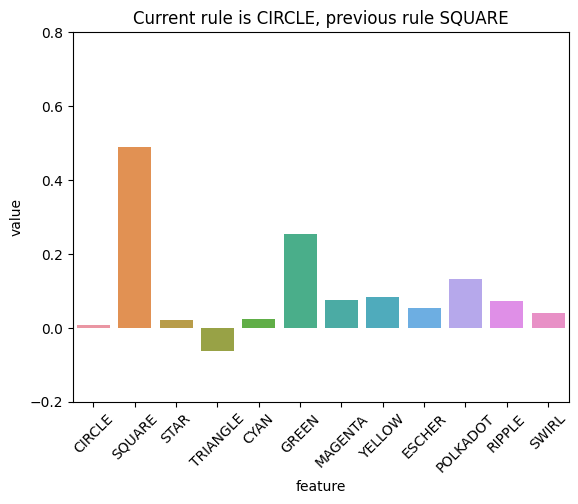

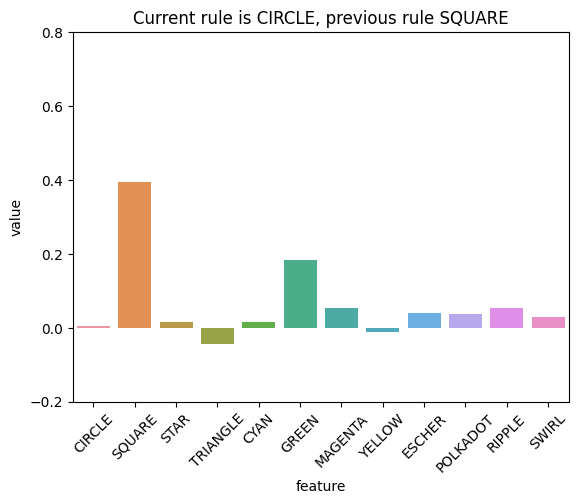

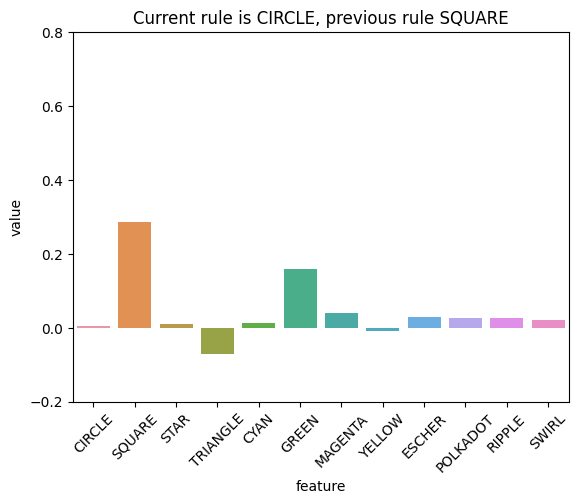

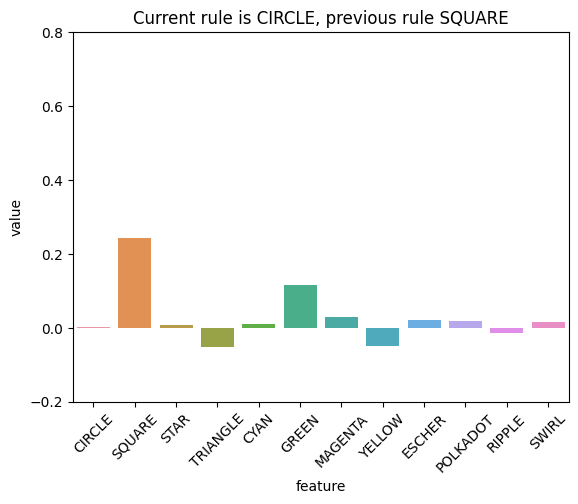

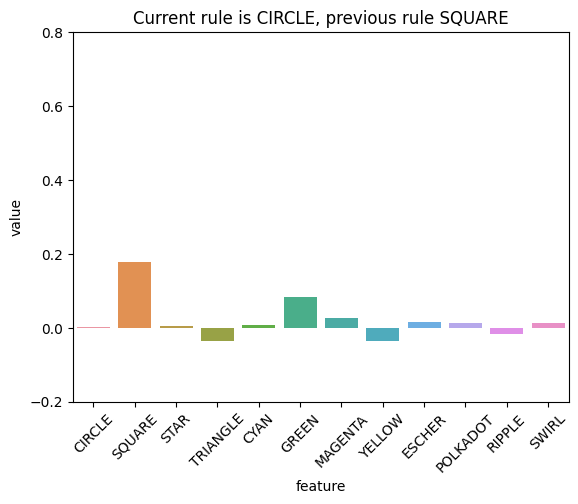

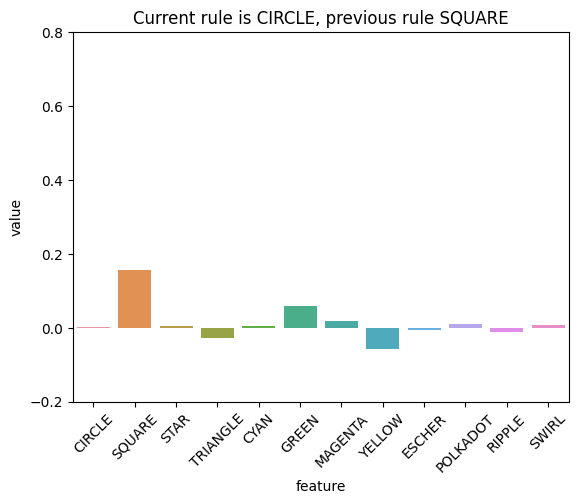

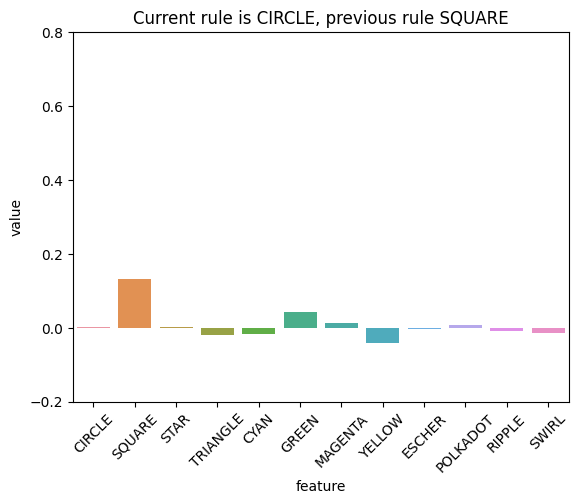

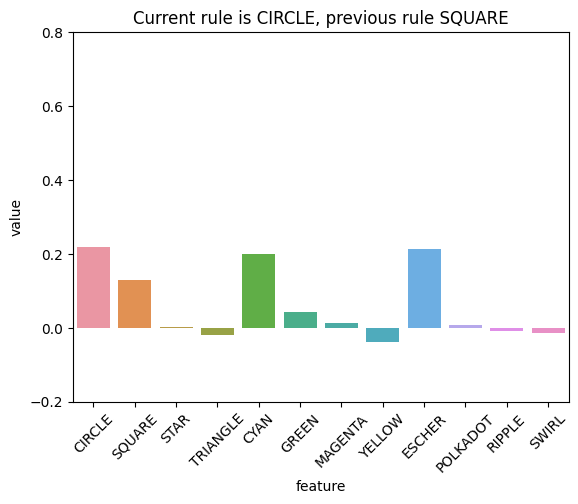

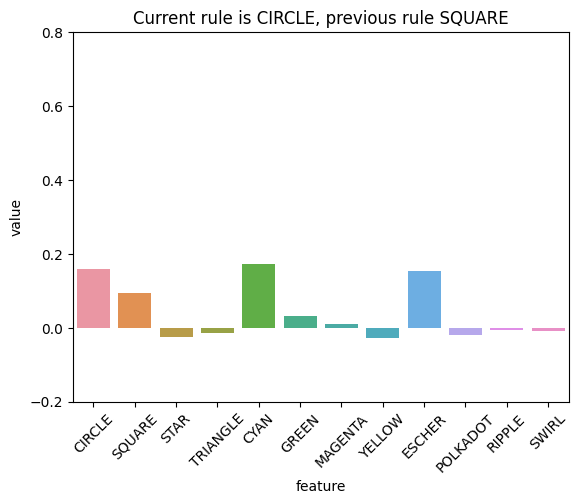

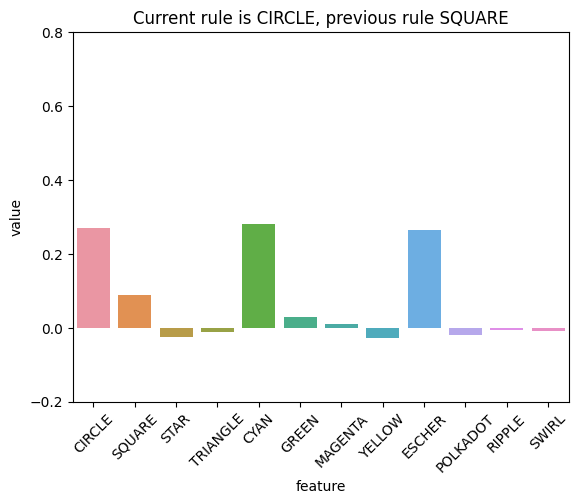

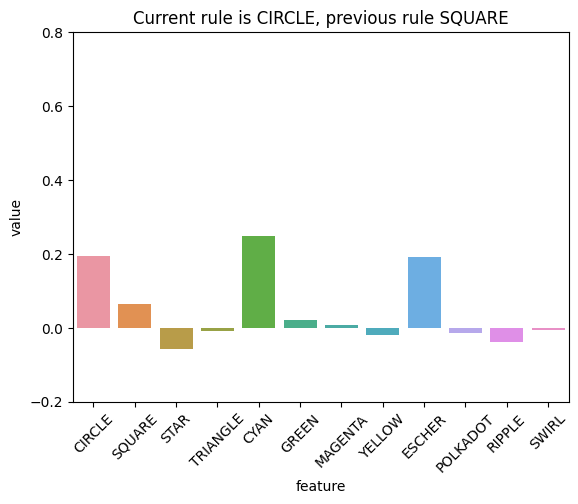

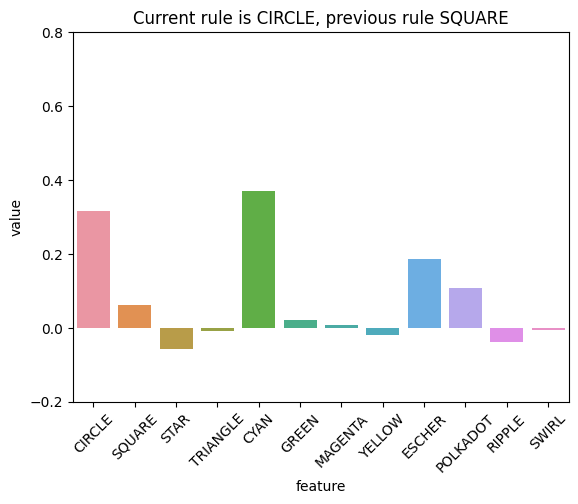

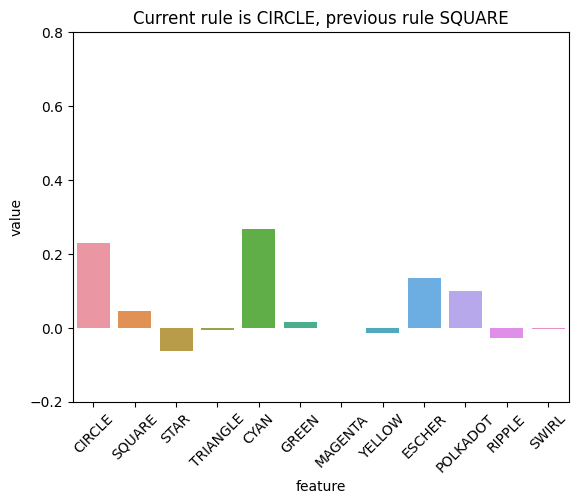

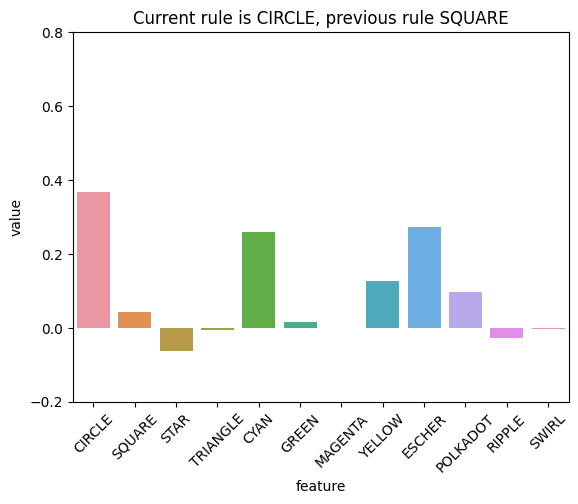

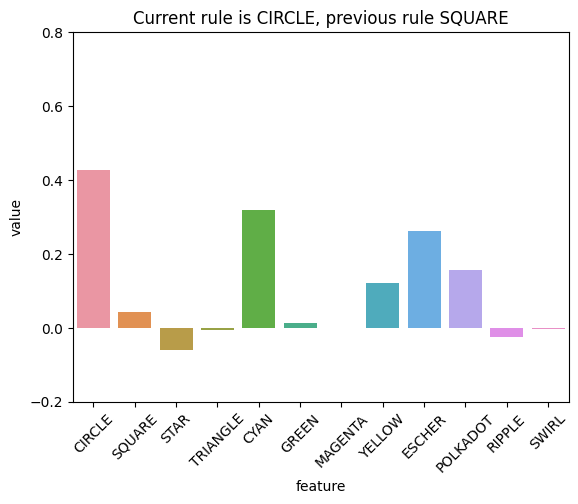

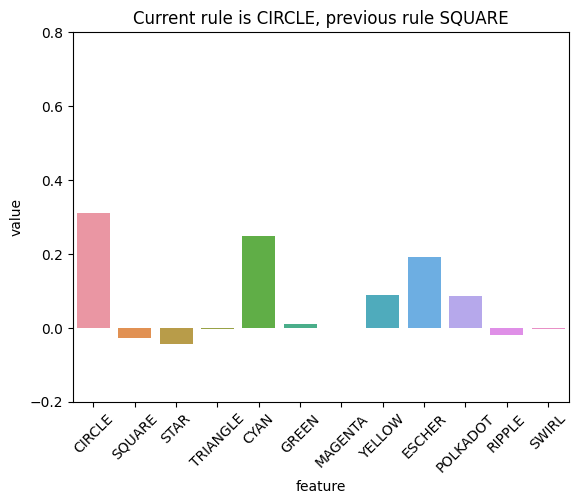

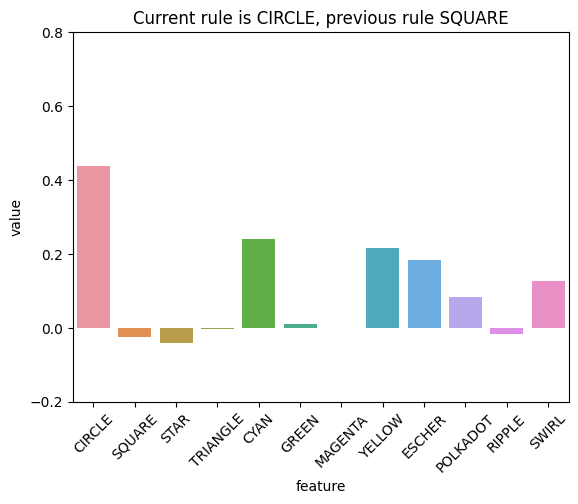

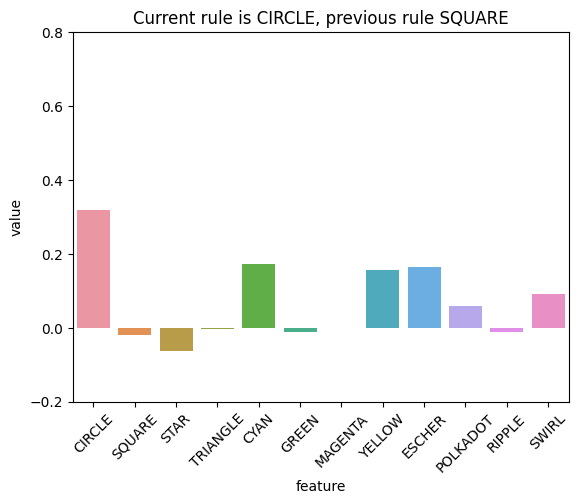

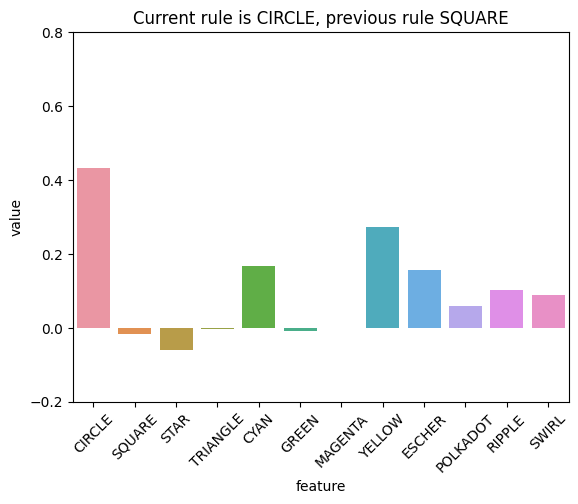

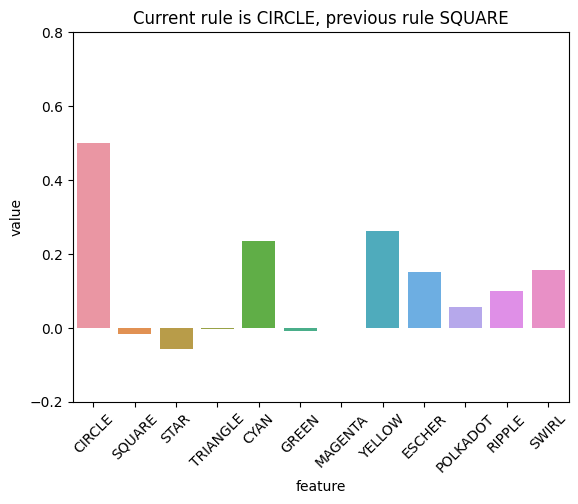

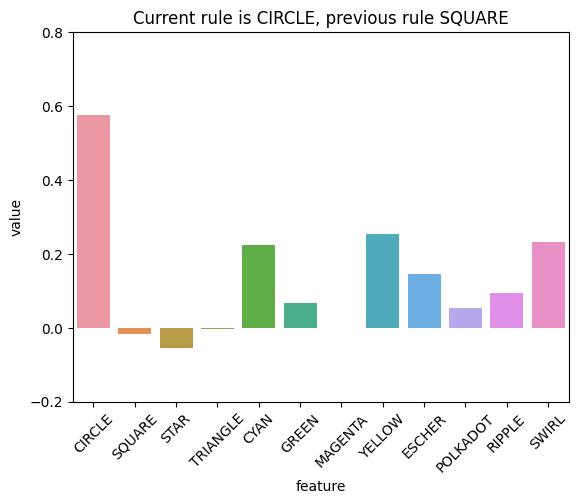

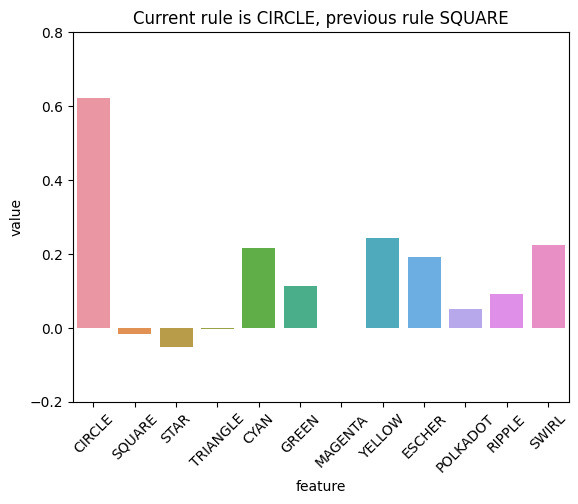

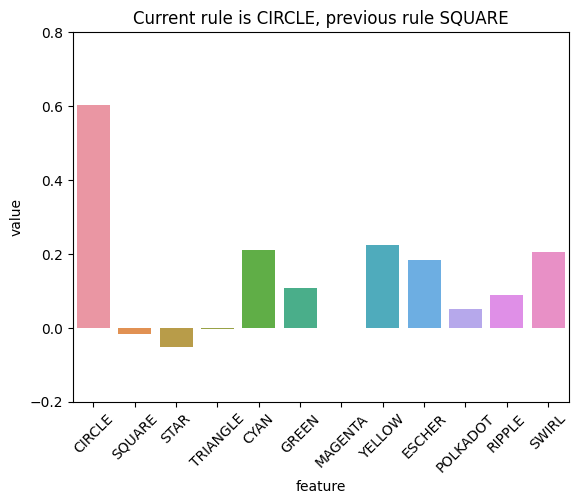

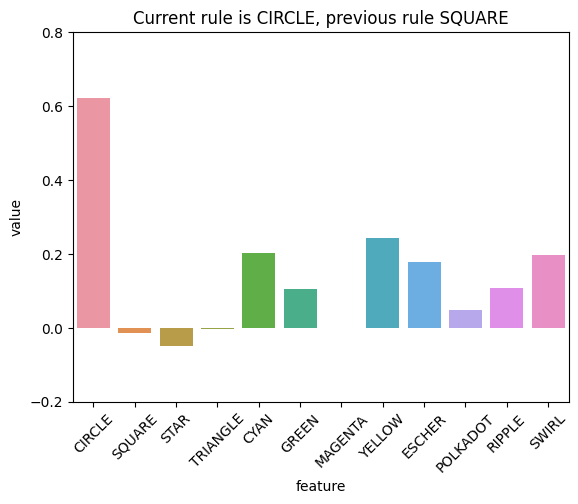

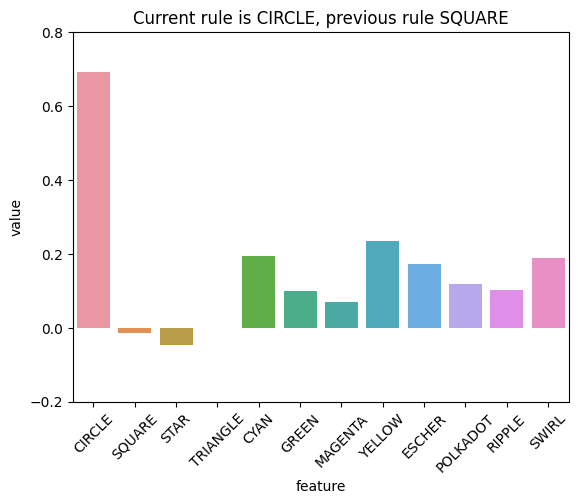

In [22]:
for i, row in block.iterrows():
    fig, ax = plt.subplots()

    res_df = row.to_frame().T
    rename_map = {f"{feat}Value": feat for feat in FEATURES}
    res_df = res_df.rename(columns=rename_map)
    melted = pd.melt(res_df, value_vars=FEATURES, var_name="feature", value_name="value")
    visualization_utils.plot_bars_by_cat(melted, "value", "feature", ax, order=FEATURES)
    ax.set_ylim([-0.2, 0.8])
    ax.set_title("Current rule is CIRCLE, previous rule SQUARE")
    fig.savefig(f"/data/patrick_res/figures/value_gif/{row.TrialAfterRuleChange}.png")